In [1]:
import django
import pandas as pd
import requests
django.setup()

In [2]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.db.models.functions import Cast
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *
from django.db.models import Sum

In [3]:
josh_op = Slot.objects.filter(employee__name='Josh',shift__name='OP')
print([op.workday.days_away for op in josh_op])

[-69, -61, -46, 31]


In [4]:
tallies = tally(list(Slot.objects.filled().filter(shift__name="7C").values_list('employee__name',flat=True)))
df = pd.DataFrame.from_dict(sortDict(tallies,reverse=True), orient='index', columns=['count'])
df


,count
Blake,48
Cheryl,44
Tiffany,34
Jaden,33
Mandy,33
Josh,31
David,27
Trisha,26
Teddy,24
Leslie,9


<AxesSubplot:title={'center':'OP Tally'}>

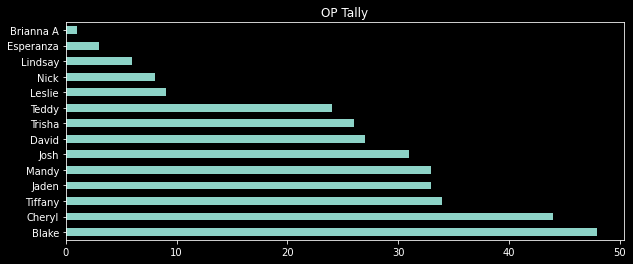

In [5]:

df.plot(figsize=(10,4),title='OP Tally',kind='barh',legend=False)

In [6]:
sch = Schedule.objects.first()

#scheduleHours, query slots that match employee and schedule = sch , then sum the shift__hours
empls = Employee.objects.annotate(scheduleHours=Sum('slots__shift__hours',filter=Q(slots__schedule=sch))).order_by('-scheduleHours')
# standard schedule Hours should be 240 * the employees fte field
empls = empls.annotate(standardScheduleHours=240*F('fte'))
empls = empls.annotate(percentScheduled=F('scheduleHours')/F('standardScheduleHours')*100)
data = empls.values('name','scheduleHours','standardScheduleHours','percentScheduled')
df = pd.DataFrame.from_records(data)
df

,name,scheduleHours,standardScheduleHours,percentScheduled
0,Esperanza,300.0,240.0,125.000000
1,Danica,290.0,240.0,120.833333
2,Mona,270.0,240.0,112.500000
3,Brianna A,240.0,240.0,100.000000
4,Brittanie,216.0,240.0,90.000000
5,Sabrina,200.0,120.0,166.666667
6,Amanda,190.0,210.0,90.476190
7,Elisia,180.0,240.0,75.000000
8,Michael,180.0,210.0,85.714286
9,Josh,158.0,240.0,65.833333


In [7]:
def sch_solve_with_lookbehind (request, schid):
    sch = Schedule.objects.get(slug=schid)
    success_bucket = []
    emptySlots = sch.slots.empty().order_by('?')
    for slot in emptySlots:
        if slot.workday.sd_id != 0:
            prev = slot.workday.prevWD().slots.filter(shift__start__hour__lte=slot.shift.start.hour+1, shift__start__hour__gte=slot.shift.start.hour-1)
            choices = []
            for p in prev:
                if p.streak < p.employee.streak_pref and p.employee not in choices and p.employee in slot.workday.on_deck():
                    choices.append(p.employee)
            if len(choices) > 0:
                chosen = random.choice(choices)
                if PtoRequest.objects.filter(employee=chosen, workday=slot.workday.date).exists() == False:
                    if TemplatedDayOff.objects.filter(employee=chosen, sd_id=slot.workday.sd_id).exists() == False:
                        try:
                            slot.employee = chosen
                            slot.save()
                            success_bucket.append(slot)
                        except:
                            print(f"ERROR: {slot} could not be filled")
                    else: 
                        print(f"{chosen} has a templated day off on {slot.workday.date}")
                else:
                    print(f"{chosen} has a PTO request on {slot.workday.date}")
            else:
                print(f"No choices for {slot}")
                try:
                    slot.employee = random.choice(workday.on_deck())
                    slot.save()
                    success_bucket.append(slot)
                except:
                    print(f"ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. {slot}")
        else:
            print(f"{slot} is on First Sunday of Schedule")
    print(len(success_bucket) , "slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND")
                    

In [8]:
def emusr_distr (request, schId):
    sch = Schedule.objects.get(slug=schId)
    print (f"SCHEDULE: {sch}")
    n_pm = sch.slots.evenings().count()
    print (f"# EVENING SHIFTS: {n_pm}")
    pm_empls = Employee.objects.filter(
        time_pref__in=["PM", "XN"]
    )
    pm_empls_shifts = sum(list(pm_empls.values_list("fte", flat=True))) * 40 * 6
    print (f"{pm_empls_shifts} HRS OF EVENING SHIFTS FILLED BY PM EMPLOYEES")
    remaining_pm = n_pm - pm_empls_shifts
    full_template_empls = Employee.objects.full_template_employees().values("pk")
    am_empls_fte_sum = sum(
        list(
            Employee.objects.filter(time_pref__in=["AM"])
            .exclude(pk__in=full_template_empls)
            .values_list("fte", flat=True)
        )
    )
    print (f'{am_empls_fte_sum}   TOTAL-FTE OF MORNING EMPLOYEES')
    unfavorables = sch.slots.unfavorables().values("employee")
    unfavorables = unfavorables.annotate(
        count=Value(1, output_field=IntegerField())
    )
    unfavorables = unfavorables.values("employee").annotate(count=Sum("count"))
    print ([f'{u["employee"]}: {u["count"]} unfavorables' for u in list(unfavorables)])
    emusr_differences = list(unfavorables.values_list("count", flat=True))
    while None in emusr_differences:
        emusr_differences.remove(None)
        emusr_differences.append(0)
    if len(emusr_differences) == 0:
        emusr_differences.append(0)
    return max(emusr_differences) - min(emusr_differences)

In [9]:
emusr_distr (None, '2023-S1A')

SCHEDULE: 2023-S1A
# EVENING SHIFTS: 168
1260.0 HRS OF EVENING SHIFTS FILLED BY PM EMPLOYEES
8.0   TOTAL-FTE OF MORNING EMPLOYEES
['Brianna-A: 2 unfavorables', 'Cheryl: 1 unfavorables', 'David: 1 unfavorables', 'Esperanza: 1 unfavorables', 'Jaden: 2 unfavorables', 'Josh: 2 unfavorables', 'Teddy: 4 unfavorables', 'Tiffany: 3 unfavorables']


3

In [10]:
def tallyPlotDataGenerator (request, empId):    
    from django.db.models import Count, OuterRef, Subquery
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import urllib
    import base64
    from io import BytesIO
    import seaborn as sns
    import matplotlib.pyplot as plt
    from django.db.models import Sum
    # define a subquery that counts the occurrences of each employee/shift combination in the Slot model
    subquery = Subquery(
        Slot.objects.filter(
                employee=OuterRef('employee'),
                shift=OuterRef('shift')
            ).values('employee', 'shift').annotate(
                count=Count('*')
            ).values('count')[:1],
            output_field=models.IntegerField()
            )
    # Count n of Slots, then if A ShiftPreference exists for that employee/shift combination
    emp = Employee.objects.get(name=empId)
    shift_prefs = emp.shift_prefs.annotate(count=subquery)

    score_subquery = Subquery(
                    Slot.objects.filter(
                        employee=OuterRef('employee'),
                        shift=OuterRef('shift'),
                    ).values('employee', 'shift', 'employee__shift_prefs__priority').annotate(
                        count=Count('*')
                    ).values('count')[:1],
                    output_field=models.IntegerField()
                )
    sps = shift_prefs.annotate(
        pref_score=Subquery(
            ShiftPreference.objects.filter(
                employee=OuterRef('employee'),
                shift=OuterRef('shift')
            ).values('score')[:1]
        )
    ).annotate(
        score_count=Coalesce(score_subquery, 0)
            ).values('score').annotate(
        count=Sum('score_count')
            ).order_by('score')
            
    data = []
    for j in sps:
        for n in range(j['count']):
            data.append(j['score'])
    

    sns.kdeplot(data=data, fill=True, bw_adjust=1.5, cut=4, label=f'{emp.name}')
    sns.set_theme('paper',"dark")
    plt.style.use('dark_background')
    # change x label to "Dislike" at -3 and "Prefer" at 3
    plt.xticks([-3, 0, 3], ['Dislike', 'Neutral', 'Prefer'])
    
    
    emp = Employee.objects.get(name=empId)
    #change x labels to be from Dislike to Prefer
    plt.xticks([-2.5,2.5], ['Dislike','Prefer'])
    plt.title(f'{emp.name}\'s Shift Preference Distribution')
    # save the figure to a buffer as SVG
    plt.legend(loc='upper left')
    buf = BytesIO()
    
    plt.savefig(buf, format='png')
    # get the SVG contents as bytes and encode to base64
    svg_bytes = buf.getvalue()
    svg_base64 = base64.b64encode(svg_bytes).decode('utf-8')
    buf.close()

    return HttpResponse(svg_html)


b'<img src="data:image/png,iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZpAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/NK7nSAAAACXBIWXMAAAsTAAALEwEAmpwYAAA/KElEQVR4nO3deVhU9f4H8PfMsLqCIC7sKvsmsiiiopmgpmFqhXrVLMksvb9c2he0urfUe7PN0rCsNCU1U6wU3E1kGWVYh2WQfQABQURlm+H8/vAyiYCyzMyZM/N5Pc88wsxZ3gPIm3PO95zDA8CAEEII4Rg+2wEIIYSQ3qACI4QQwklUYIQQQjiJCowQQggnUYERQgjhJCowQgghnEQFRgghhJOowAghhHASFRghhBBOogIjhBDCSVRghBBCOIkKjBBCCCdRgRFCCOEkKjBCCCGcRAVGCCGEk6jACCGEcBIVGCGEEE6iAiOEEMJJVGCEEEI4iQqMEEIIJ1GBkS41NzcjOTkZYrEYCQkJWLhwYa+X9ccff0BfX7/D8wcOHEBQUBAA4Ny5c91a1vDhw/Hnn39CJBIhKysL3377LQBg+fLl+PjjjztM7+Pjo3h+6NChSExMRHJyMhwdHbFgwYJO17F8+XJUVFRAJBIhIyMD8+bN61a2Nv/973+Rnp6OjRs39mg+dSgoKEBKSgoyMjIgEonw0ksvKV5btWpVl18T4N7XxczMrMvXT506BQAICgrCgQMHepRrw4YNio/v/54R8jAMPejR2aO8vFzxsbOzM5OXl8eEhIQodR0HDhxggoKCGADMuXPnujXPrl27mBUrVig+d3NzYwAwy5cvZz7++OOHzhsWFsZs376dAcAEBQUxBw4c6HS6+5fl6OjIVFdXM3w+v900D37e1deuO4+HLUvZj4KCAsbQ0JABwIwcOZIRCoXMqlWrujXvuXPnGCcnp05f4/F4io8f9rVV1

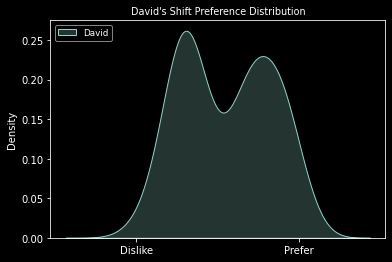

In [11]:
tallyPlotDataGenerator(None, 'David').content

In [12]:
from flow import views as flow_views

def select_max_min_employees (request, schId, exclude=[] ):
    emusr_data = flow_views.ApiViews.schedule__get_emusr_list(request,schId)
    data = json.loads(emusr_data.content)
    if exclude != []:
        for e in exclude:
            data.pop(e, None)
    max_val = max(data.values())
    max_empl = [k for k, v in data.items() if v == max_val][0]
    min_val = min(data.values())
    min_empl = [k for k, v in data.items() if v == min_val][0]
    return (max_empl, min_empl)
        
def get_tradable_slots (request, schId, emplA, emplB):
    tradables = []
    sch = Schedule.objects.get(slug=schId)
    # get evening slots of emplA, where emplB is in a morning slot on the same day 
    pmSlots = sch.slots.filter(employee__name=emplA, shift__group__in=['PM','XN'])
    for slot in pmSlots:
        if slot.workday.slots.filter(employee__name=emplB, shift__group__in=['AM']).exists():
            tradables.append(slot.pk)
    tradables = Slot.objects.filter(pk__in=tradables)
    print(f'Potenital Trades: {tradables.count()}')
    # filter out exceptions
    for slot in tradables:
        if slot.workday.sd_id != 41:
            if slot.workday.nextWD().slots.filter(employee__name=emplA, shift__group__in=['AM']).exists():
                tradables = tradables.exclude(pk=slot.pk)
                print(f'Slot Excluded because {emplA} has an AM shift on the next day')
        if slot.workday.sd_id != 0:
            if slot.workday.prevWD().slots.filter(employee__name=emplB, shift__group__in=['PM','XN']).exists():
                tradables = tradables.exclude(pk=slot.pk)
                print(f'Slot Excluded because {emplB} has a PM shift on the previous day')
        if not slot.shift.trained.filter(name=emplB).exists():
            tradables = tradables.exclude(pk=slot.pk)
            print(f'Slot Excluded because {emplB} is not trained for {slot.shift}')
        

    return tradables

In [13]:
maxEmpl, minEmpl = select_max_min_employees(None, '2023-S1A', ["Mandy","Blake"])
maxEmpl, minEmpl

('Teddy', 'Trisha')

In [14]:
get_tradable_slots(None, '2023-S1A', maxEmpl, minEmpl)

Potenital Trades: 0


<SlotManager []>

In [15]:
d = dict()
slot = Slot.objects.all()[500]
emps = Employee.objects.all().annotate(schHours=F('fte')*240).values('name','schHours')
for e in emps:
    d[e['name']] = e['schHours']
sch = slot.schedule
# for min in d get sch.slots.fills_with(min)
min_empl = min(d, key=d.get)
# exclude if empl is in slot on same day
for s in sch.slots.filter(employee__name=min_empl):
    if s.siblings_day.filter(employee__name=min_empl).exists():
        s.siblings_day.filter(employee__name=min_empl).update(fills_with__remove=[min_empl])


In [16]:
sch.actions.clearPmEmployeesAmShifts(sch)
sch.percent
sch.START_DATES

{2022: [datetime.date(2022, 1, 23),
  datetime.date(2022, 3, 6),
  datetime.date(2022, 4, 17),
  datetime.date(2022, 5, 29),
  datetime.date(2022, 7, 10),
  datetime.date(2022, 8, 21),
  datetime.date(2022, 10, 2),
  datetime.date(2022, 11, 13),
  datetime.date(2022, 12, 25)],
 2023: [datetime.date(2023, 2, 5),
  datetime.date(2023, 3, 19),
  datetime.date(2023, 4, 30),
  datetime.date(2023, 6, 11),
  datetime.date(2023, 7, 23),
  datetime.date(2023, 9, 3),
  datetime.date(2023, 10, 15),
  datetime.date(2023, 11, 26)],
 2024: [datetime.date(2024, 1, 7),
  datetime.date(2024, 2, 18),
  datetime.date(2024, 3, 31),
  datetime.date(2024, 5, 12),
  datetime.date(2024, 6, 23),
  datetime.date(2024, 8, 4),
  datetime.date(2024, 9, 15),
  datetime.date(2024, 10, 27),
  datetime.date(2024, 12, 8)],
 2025: [datetime.date(2025, 1, 19),
  datetime.date(2025, 3, 2),
  datetime.date(2025, 4, 13),
  datetime.date(2025, 5, 25),
  datetime.date(2025, 7, 6),
  datetime.date(2025, 8, 17),
  datetime.date

In [17]:
def payPeriodFiller(schId):
    sch = Schedule.objects.get(slug=schId)
    for pd in sch.periods.all():
        empties = pd.slots.empty().all()
        print(f'Checking {empties.count()} slots')
        for e in empties:
            e.save()
            count = e.fills_with.count()
            if count > 0:
                print (e, '  checking...')
                empls = list(pd.needed_hours())
                for empl in empls:
                    print (empl)
                    if e.fills_with.filter(name=empl).exists():
                        if e.workday.slots.filter(employee=empl).exists() == False:
                            e.employee = empl
                            print ('    FILLING SLOT:', e, 'with', empl)
                            e.save()
                        else:
                            print ('    skipping employee because they already have a shift')
                    else:
                        print ('  skipping employee because they are not trained for this shift')
            else:
                print ('  skipping slot because it is already filled')

